In [2]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string 

In [3]:
df = pd.read_csv('cyber-threat-intelligence_all2.csv')

In [4]:
df.head()

,Unnamed: 0,index,text,entities,relations,Comments,id,label,start_offset,end_offset
0,0,1.0,This post is also available in: 日本語 (Japa...,"[{'id': 45800, 'label': 'malware', 'start_offs...",[],[],45800.0,malware,288.0,300.0
1,1,2.0,The attack vector is very basic and repeats it...,"[{'id': 48941, 'label': 'attack-pattern', 'sta...",[],[],48941.0,attack-pattern,69.0,115.0
2,2,3.0,Once executed by the user the first stage malw...,[],[],[],NaN,NaN,NaN,NaN
3,3,4.0,The first known campaign was launched by Crim...,"[{'id': 45806, 'label': 'TIME', 'start_offset'...",[],[],45806.0,TIME,55.0,68.0
4,4,5.0,The first stage downloaded the ransomware from...,[],[],[],NaN,NaN,NaN,NaN


In [5]:
#Display quick summary of Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19940 entries, 0 to 19939
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    19940 non-null  int64  
 1   index         19464 non-null  float64
 2   text          19940 non-null  object 
 3   entities      19464 non-null  object 
 4   relations     19464 non-null  object 
 5   Comments      19464 non-null  object 
 6   id            9462 non-null   float64
 7   label         9938 non-null   object 
 8   start_offset  9462 non-null   float64
 9   end_offset    9462 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 1.5+ MB


In [7]:
#Remove unnamed column
df.drop(df.columns[df.columns.str.contains(
    'unnamed', case=False)], axis=1, inplace=True)

In [8]:
#recheck
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19940 entries, 0 to 19939
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         19464 non-null  float64
 1   text          19940 non-null  object 
 2   entities      19464 non-null  object 
 3   relations     19464 non-null  object 
 4   Comments      19464 non-null  object 
 5   id            9462 non-null   float64
 6   label         9938 non-null   object 
 7   start_offset  9462 non-null   float64
 8   end_offset    9462 non-null   float64
dtypes: float64(4), object(5)
memory usage: 1.4+ MB


In [9]:
#Replace missing values
df.loc[df['label'].isna(), 'label'] = 'benign'

In [10]:
#Replace all the missing values in the DataFrame with 0
df=df.fillna(0)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19940 entries, 0 to 19939
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         19940 non-null  float64
 1   text          19940 non-null  object 
 2   entities      19940 non-null  object 
 3   relations     19940 non-null  object 
 4   Comments      19940 non-null  object 
 5   id            19940 non-null  float64
 6   label         19940 non-null  object 
 7   start_offset  19940 non-null  float64
 8   end_offset    19940 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.4+ MB


In [12]:
#Return an array of unique values in the label column
df['label'].unique()

array(['malware', 'attack-pattern', 'benign', 'TIME', 'identity',
       'SOFTWARE', 'threat-actor', 'location', 'tools', 'FILEPATH',
       'SHA2', 'vulnerability', 'URL', 'DOMAIN', 'IPV4', 'campaign',
       'EMAIL', 'REGISTRYKEY', 'SHA1', 'Infrastucture', 'MD5', 'url',
       'hash'], dtype=object)

In [13]:
#Create new dataframe
data = df[['text','label']]

In [14]:
#Lemmatization
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

In [15]:
#Tokenization
def preprocess_text(text):
    tokens = word_tokenize(text)

    tokens = [token.lower() for token in tokens if token not in punctuations]

    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    tokens = [token for token in tokens if token not in stop_words]

    processed_text = ' '.join(tokens)
    
    return processed_text

In [16]:
data['text_new'] = data['text'].apply(preprocess_text)

C:\Users\arune\AppData\Local\Temp\ipykernel_33824\3005584527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_new'] = data['text'].apply(preprocess_text)


In [17]:
#Drop 'text' column from 'data' DataFrame
data = data.drop(labels=['text'],axis=1)

In [18]:
#Replace all non-alphanumeric and non-whitespace characters of the tex_new column with an empty string
data['text_new'] = data['text_new'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

In [22]:
data.head()

,label,text_new
0,malware,post also available japanese ctblocker wellkn...
1,attack-pattern,attack vector basic repeat begin spear phishin...
2,benign,executed user first stage malware downloads ex...
3,TIME,first known campaign wa launched crimeware nov...
4,benign,first stage downloaded ransomware site


In [23]:
#show the number of tuples
data.shape

(19940, 2)

In [24]:
#Update values in the Label based on certain conditions
data.label.loc[(data['label']=="MD5") | (data['label']=="REGISTRYKEY") | (data['label']=="EMAIL") |  (data['label']=="Infrastucture") | (data['label']=="DOMAIN") | (data['label']=="SHA1") | (data['label']=="IPV4") | (data['label']=="campaign") | (data['label']=="URL") | (data['label']=="SHA2") | (data['label']=="vulnerability") | (data['label']=="FILEPATH") | (data['label']=="tools") | (data['label']=="TIME") | (data['label']=="url") | (data['label']=="hash") ] = "NEED_ATTENTION"

In [25]:
#List the number of occurrences in each uniques value
data['label'].value_counts()

label
benign            10002
NEED_ATTENTION     2132
malware            1911
location           1405
SOFTWARE           1229
attack-pattern     1206
identity           1165
threat-actor        890
Name: count, dtype: int64

In [26]:
#Calculate maximum number of string in the text_new column
max_length = data['text_new'].str.len().max()
max_length

4655

In [27]:
#calculate maximum number of tokens
max_length_tokens = data['text_new'].apply(lambda x: len(x.split())).max()

In [28]:
#Calculate maximum sequence lenth
max_length_characters = data['text_new'].apply(lambda x: len(x)).max()

print('Maximum Sequence Length (Tokens):', max_length_tokens)
print('Maximum Sequence Length (Characters):', max_length_characters)

Maximum Sequence Length (Tokens): 451
Maximum Sequence Length (Characters): 4655


In [29]:
#Limit inputs
MAX_NB_WORDS = 50000
MAX_SEQ_LENGTH = 450
EMBEDDING_DIM=100

In [30]:
#Rename text_new to text
data = data.rename(columns={'text_new': 'text'})

In [31]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%()*+,-./:;<=>?@[\]^_`{|}',lower=True)
tokenizer.fit_on_texts(data['text'].values)

In [32]:
word_index = tokenizer.word_index
len(word_index)

11934

In [33]:
#Convert text data into integers
X = tokenizer.texts_to_sequences(data['text'].values) 
X = pad_sequences(X,maxlen=MAX_SEQ_LENGTH)

In [34]:
X

array([[   0,    0,    0, ..., 1943, 1718, 4837],
       [   0,    0,    0, ...,  343, 1916, 6560],
       [   0,    0,    0, ...,  533,   18,  181],
       ...,
       [   0,    0,    0, ...,  257,    2,   18],
       [   0,    0,    0, ..., 1374, 1828, 2238],
       [   0,    0,    0, ...,   16,   26,   39]])

In [35]:
X.shape

(19940, 450)

In [36]:
Y = pd.get_dummies(data['label']).values

In [37]:
from sklearn.preprocessing import LabelBinarizer
# One-hot encoding using LabelBinarizer
lb = LabelBinarizer()
Y = lb.fit_transform(data['label'])

In [38]:
Y

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [39]:
Y.shape

(19940, 8)

In [40]:
#Split data into training sets and testing sets
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.20,random_state=42)

In [41]:
model=Sequential()
model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=X.shape[1]))
model.add(LSTM(150,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(8,activation='softmax'))

C:\Users\arune\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
encoder_vocab = 1000
model.add(Embedding(input_dim=encoder_vocab, output_dim=64))

In [44]:
model=Sequential()
model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=X.shape[1]))
model.add(LSTM(150,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(8,activation='softmax'))

In [45]:
model=Sequential()
model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM))
model.add(LSTM(150,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(8,activation='softmax'))

In [46]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
model=Sequential()
model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=X.shape[1]))
model.add(LSTM(150,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(8,activation='softmax'))

In [48]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
#Save the model to the system
model.save_weights("model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [51]:
#Train machine learning model
epochs=10
batch_size=64
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 85s 407ms/step - accuracy: 0.4904 - loss: 1.5937 - val_accuracy: 0.5898 - val_loss: 1.2489
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 89s 445ms/step - accuracy: 0.6541 - loss: 1.0466 - val_accuracy: 0.7424 - val_loss: 0.8444
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 85s 425ms/step - accuracy: 0.8432 - loss: 0.5185 - val_accuracy: 0.8010 - val_loss: 0.7077
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 85s 424ms/step - accuracy: 0.9117 - loss: 0.2895 - val_accuracy: 0.8395 - val_loss: 0.6726
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 94s 470ms/step - accuracy: 0.9402 - loss: 0.2047 - val_accuracy: 0.8490 - val_loss: 0.6204
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 409ms/step - accuracy: 0.9532 - loss: 0.1641 - val_accuracy: 0.8565 - val_loss: 0.6717
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 403ms/step - accuracy: 0.9562 - loss: 0.1359 - val_accuracy: 0.8562 - val_loss: 0.7047
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 411ms/step - accuracy: 0.9633 - loss: 0

In [52]:
#evaluate the performance of trained model
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8547 - loss: 0.6599
Test set
  Loss: 0.667
  Accuracy: 0.858


In [53]:
#predict dataset and compare it with actual labes
predictions = model.predict(x_test)
for i in range(5):
    print('Prediction: {}'.format(predictions[i]))
    print('Actual: {}'.format(y_test[i]))

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step
Prediction: [9.7399974e-01 1.4814870e-04 7.1955578e-06 1.4975608e-07 1.3021950e-06
 7.4932614e-05 2.5767781e-02 7.7473521e-07]
Actual: [1 0 0 0 0 0 0 0]
Prediction: [3.2240197e-05 1.3032131e-05 7.7572452e-07 9.9989617e-01 7.4921394e-07
 1.3475212e-05 4.3509724e-05 8.3901540e-08]
Actual: [0 0 0 1 0 0 0 0]
Prediction: [1.2452004e-03 4.2445210e-04 2.9183018e-05 5.7197624e-04 1.9584993e-04
 6.3476507e-03 9.9060166e-01 5.8399944e-04]
Actual: [0 0 0 0 0 0 1 0]
Prediction: [3.8085226e-04 9.7603828e-01 2.7808055e-06 2.3452839e-02 1.7250915e-05
 3.7077229e-05 7.0539732e-05 3.0514170e-07]
Actual: [0 1 0 0 0 0 0 0]
Prediction: [1.5999219e-06 8.8641727e-06 9.7547500e-06 9.9995959e-01 6.7335277e-06
 1.6346719e-06 4.6678183e-06 7.1121176e-06]
Actual: [0 0 0 1 0 0 0 0]


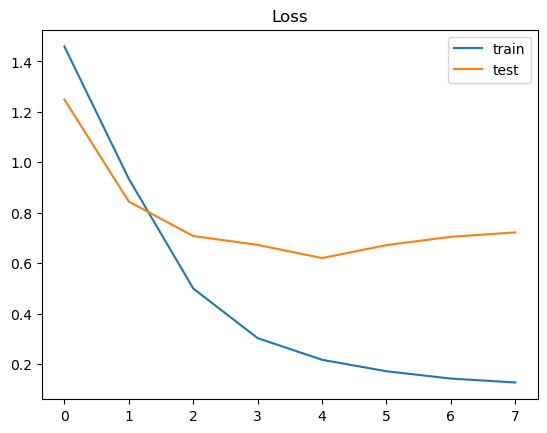

In [54]:
import matplotlib.pyplot as plt
#show training and validation loss curve
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [55]:
#get predicted class label for test data
y_pred = np.argmax(model.predict(x_test), axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step


In [56]:
class_labels = lb.classes_

print(class_labels)

['NEED_ATTENTION' 'SOFTWARE' 'attack-pattern' 'benign' 'identity'
 'location' 'malware' 'threat-actor']


125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step


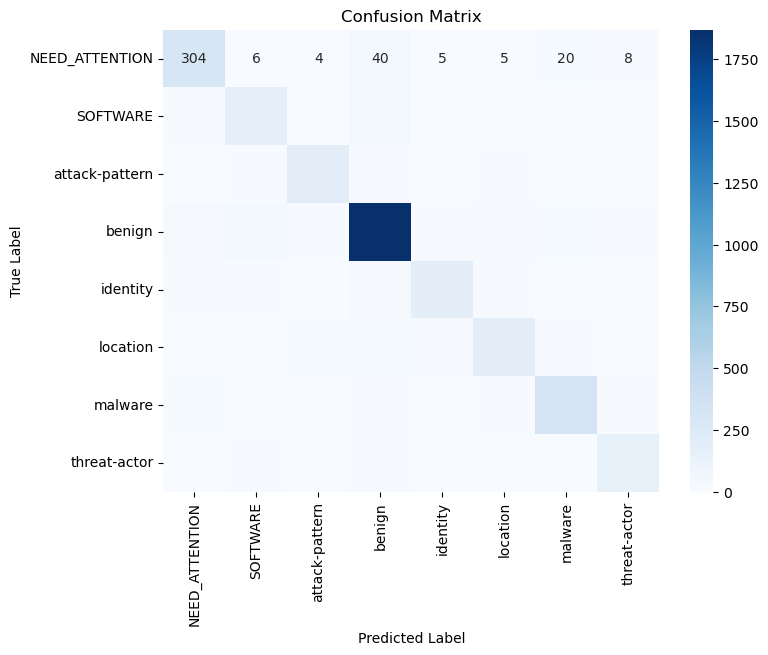

In [57]:
#Generation and visualization of confusion matrix using a heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

classes = np.arange(len(cm))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [58]:
#calculate the accuracy of machine learning model based on the confusion matrix
accuracy = (cm.diagonal().sum()) / cm.sum()
accuracy

0.8583249749247743

In [59]:
#calculate precision of the model based on confusion matrix
precision = cm.diagonal() / cm.sum(axis=0)
precision

array([0.8       , 0.69379845, 0.80645161, 0.92341897, 0.82743363,
       0.75769231, 0.83541147, 0.79581152])

In [60]:
#calculate true positive rate or recall based on confusion matrix
recall = cm.diagonal() / cm.sum(axis=1)
recall

array([0.7755102 , 0.73360656, 0.79365079, 0.93170489, 0.73622047,
       0.74621212, 0.86340206, 0.80851064])

In [61]:
#calculate f1 score
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score

array([0.78756477, 0.71314741, 0.8       , 0.92754342, 0.77916667,
       0.7519084 , 0.84917617, 0.80211082])

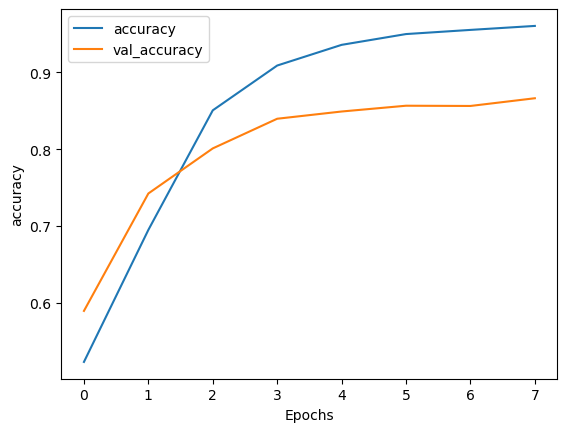

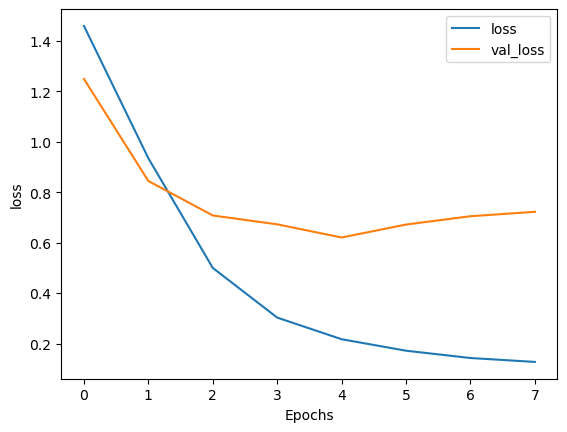

In [62]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [68]:
import re

def extract_features(text):
    features = {
        'keyword_malware': 1 if 'malware' in text.lower() else 0,
        'keyword_virus': 1 if 'virus' in text.lower() else 0,
        'keyword_trojan': 1 if 'trojan' in text.lower() else 0,
        'keyword_attack': 1 if 'attack' in text.lower() else 0,
        'keyword_exploit': 1 if 'exploit' in text.lower() else 0,
        'text_length': len(text),
        'num_urls': len(re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text))
    }
    return features

In [69]:
data['features'] = data['text'].apply(extract_features)

In [73]:
#Apply rules for threat classification
def apply_rules(features):
    if features['keyword_malware'] == 1 or features['keyword_virus'] == 1:
        if features['text_length'] > 100:
            return 'HIGH_PRIORITY'
        else:
            return 'MEDIUM_PRIORITY'
    else:
        return 'LOW_PRIORITY'

In [71]:
data['triage_category'] = data['features'].apply(apply_rules)

In [72]:
confusion_matrix(data['label'], data['triage_category'])

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 148, 1924,   60,    0,    0,    0,    0,    0,    0,    0,    0],
       [  71, 1131,   27,    0,    0,    0,    0,    0,    0,    0,    0],
       [  62, 1097,   47,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 220, 9394,  388,    0,    0,    0,    0,    0,    0,    0,    0],
       [  40, 1111,   14,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 165, 1194,   46,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 181, 1590,  140,    0,    0,    0,    0,    0,    0,    0,    0],
       [  79,  778,   33,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)